In [11]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats import mode
import random
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

In [2]:
result_files = glob.glob('../results/dvlog-baseline-model-size-ablation/*.csv')

dfs = []
for file in result_files:
    df = pd.read_csv(file)

    # get seconds_per_window
    df['seconds_per_window'] = int(file.split(':')[-2].split('-')[3])
    df['num_layers'] = int(file.split(':')[-2].split('-')[5])
    df['num_heads'] = int(file.split(':')[-2].split('-')[6][-1:])
    df['head_dim'] = int(file.split(':')[-2].split('-')[7][-2:])
    df['run_id'] = int(file.split(':')[-2].split('-')[9])

    dfs.append(df)

dfs = pd.concat(dfs)
    

In [3]:
result_files_old = glob.glob('../results/baseline-ws-ablation-final/*.csv')

dfs_old = []
for file in result_files_old:
    df = pd.read_csv(file)

    # get seconds_per_window
    df['seconds_per_window'] = int(file.split(':')[-2].split('-')[2])
    df['num_layers'] = 4
    df['num_heads'] = 8
    df['head_dim'] = 64
    df['run_id'] = int(file.split(':')[-2].split('-')[4])

    dfs_old.append(df)

dfs_old = pd.concat(dfs_old)

In [4]:
from collections import defaultdict

def manipulate_predictions(df, source_dir):
    new_df = defaultdict(list)
    
    for i, row in df.iterrows():
        # temporal-evaluator:baseline-ws-ablation-final:window-size-3-run-1:over-time:validation.json
        name = f"temporal-evaluator:{row['name']}:over-time:validation.json"
        with open(f'../results/{source_dir}/{name}', 'rt') as f:
            data = json.load(f)

        preds = []
        true_labels = []
        for key, value in data.items():
            the_preds = np.array(value['preds'])

            # get preds over threshold of 0.25 and 0.75
            min_threshold = 0.35
            max_threshold = 0.65

            positive_predictions = np.ceil(the_preds[the_preds > max_threshold]).astype(np.int32)
            negative_predictions = np.floor(the_preds[the_preds < min_threshold]).astype(np.int32)

            tpreds = np.concatenate([positive_predictions, negative_predictions])

            if not len(tpreds):
                the_mode = the_preds.mean() > 0.5 # if no preds, use mean
            else:
                the_mode = mode(tpreds)[0][0]

            # if the_mode != value['true_label']:
            #     print(key, the_mode, value['true_label'], the_preds.mean())

            # get mode of preds
            preds.append(the_mode)
            true_labels.append(value['true_label'])

        f1 = f1_score(true_labels, preds)
        precision = precision_score(true_labels, preds)
        recall = recall_score(true_labels, preds)
        accuracy = accuracy_score(true_labels, preds)

        new_df['f1'].append(f1)
        new_df['recall'].append(recall)
        new_df['precision'].append(precision)
        new_df['accuracy'].append(accuracy)
        new_df['seconds_per_window'].append(row['seconds_per_window'])
        new_df['num_layers'].append(row['num_layers'])
        new_df['num_heads'].append(row['num_heads'])
        new_df['head_dim'].append(row['head_dim'])
        new_df['run_id'].append(row['run_id'])

    new_df = pd.DataFrame(new_df)
    return new_df


In [5]:
df_ana = dfs_old[(dfs_old['prediction_kind'] == 'mean') & (dfs_old['dataset_kind'] == 'test')].reset_index(drop = True)
df_david = dfs[(dfs['prediction_kind'] == 'mean') & (dfs['dataset_kind'] == 'test')]

df_david.groupby(['num_layers', 'num_heads', 'head_dim', 'seconds_per_window']).mean().reset_index().sort_values('f1')

/tmp/ipykernel_1176102/1017110247.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_david.groupby(['num_layers', 'num_heads', 'head_dim', 'seconds_per_window']).mean().reset_index().sort_values('f1')


,num_layers,num_heads,head_dim,seconds_per_window,f1,recall,precision,auc,accuracy,run_id
1,8,4,64,9,0.727091,0.789644,0.682051,0.777188,0.677249,2.0
3,8,8,32,9,0.736556,0.770227,0.712012,0.798149,0.701940,2.0
0,8,4,64,6,0.738274,0.831715,0.667942,0.770076,0.677249,2.0
2,8,8,32,6,0.746739,0.799353,0.702411,0.792692,0.705467,2.0


In [6]:
df_old = dfs_old[
    (dfs_old['prediction_kind'] == 'mean') & (dfs_old['dataset_kind'] == 'test')
].groupby(['num_layers', 'num_heads', 'head_dim', 'seconds_per_window']).mean().reset_index().sort_values('f1')

/tmp/ipykernel_1176102/2777490991.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_old = dfs_old[


In [7]:
manipulated_df_old = manipulate_predictions(df_ana, 'baseline-ws-ablation-final')
manipulated_df_new = manipulate_predictions(df_david, 'dvlog-baseline-model-size-ablation')

<AxesSubplot:xlabel='seconds_per_window', ylabel='f1'>

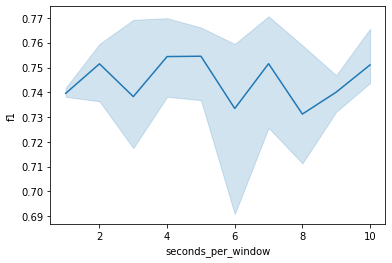

In [8]:
df_plot = dfs_old[(dfs_old['prediction_kind'] == 'mean') & (dfs_old['dataset_kind'] == 'test')].reset_index(drop = True)
# df_plot

sns.lineplot(
    data = df_plot, 
    x = 'seconds_per_window', 
    y = 'f1', 
)


In [9]:
manipulated_df_old.groupby(['num_layers', 'num_heads', 'head_dim', 'seconds_per_window']).mean().reset_index().sort_values('f1')

,num_layers,num_heads,head_dim,seconds_per_window,f1,recall,precision,accuracy,run_id
4,4,8,64,5,0.738028,0.802721,0.689123,0.702128,2.0
5,4,8,64,6,0.743292,0.863946,0.661703,0.684397,2.0
0,4,8,64,1,0.751533,0.829932,0.689841,0.712766,2.0
2,4,8,64,3,0.757764,0.857143,0.683536,0.712766,2.0
9,4,8,64,10,0.762581,0.823129,0.732448,0.737589,2.0
1,4,8,64,2,0.762646,0.891156,0.673977,0.709220,2.0
3,4,8,64,4,0.770204,0.877551,0.688492,0.726950,2.0
8,4,8,64,9,0.772168,0.829932,0.723099,0.744681,2.0
6,4,8,64,7,0.774655,0.843537,0.717359,0.744681,2.0
7,4,8,64,8,0.786357,0.795918,0.783634,0.776596,2.0


In [10]:
manipulated_df_new.groupby(['num_layers', 'num_heads', 'head_dim', 'seconds_per_window']).mean().reset_index().sort_values('f1')

,num_layers,num_heads,head_dim,seconds_per_window,f1,recall,precision,accuracy,run_id
0,8,4,64,6,0.760664,0.816327,0.721417,0.730496,2.0
1,8,4,64,9,0.769033,0.850340,0.718822,0.730496,2.0
3,8,8,32,9,0.782593,0.795918,0.772164,0.769504,2.0
2,8,8,32,6,0.805148,0.816327,0.797658,0.794326,2.0
